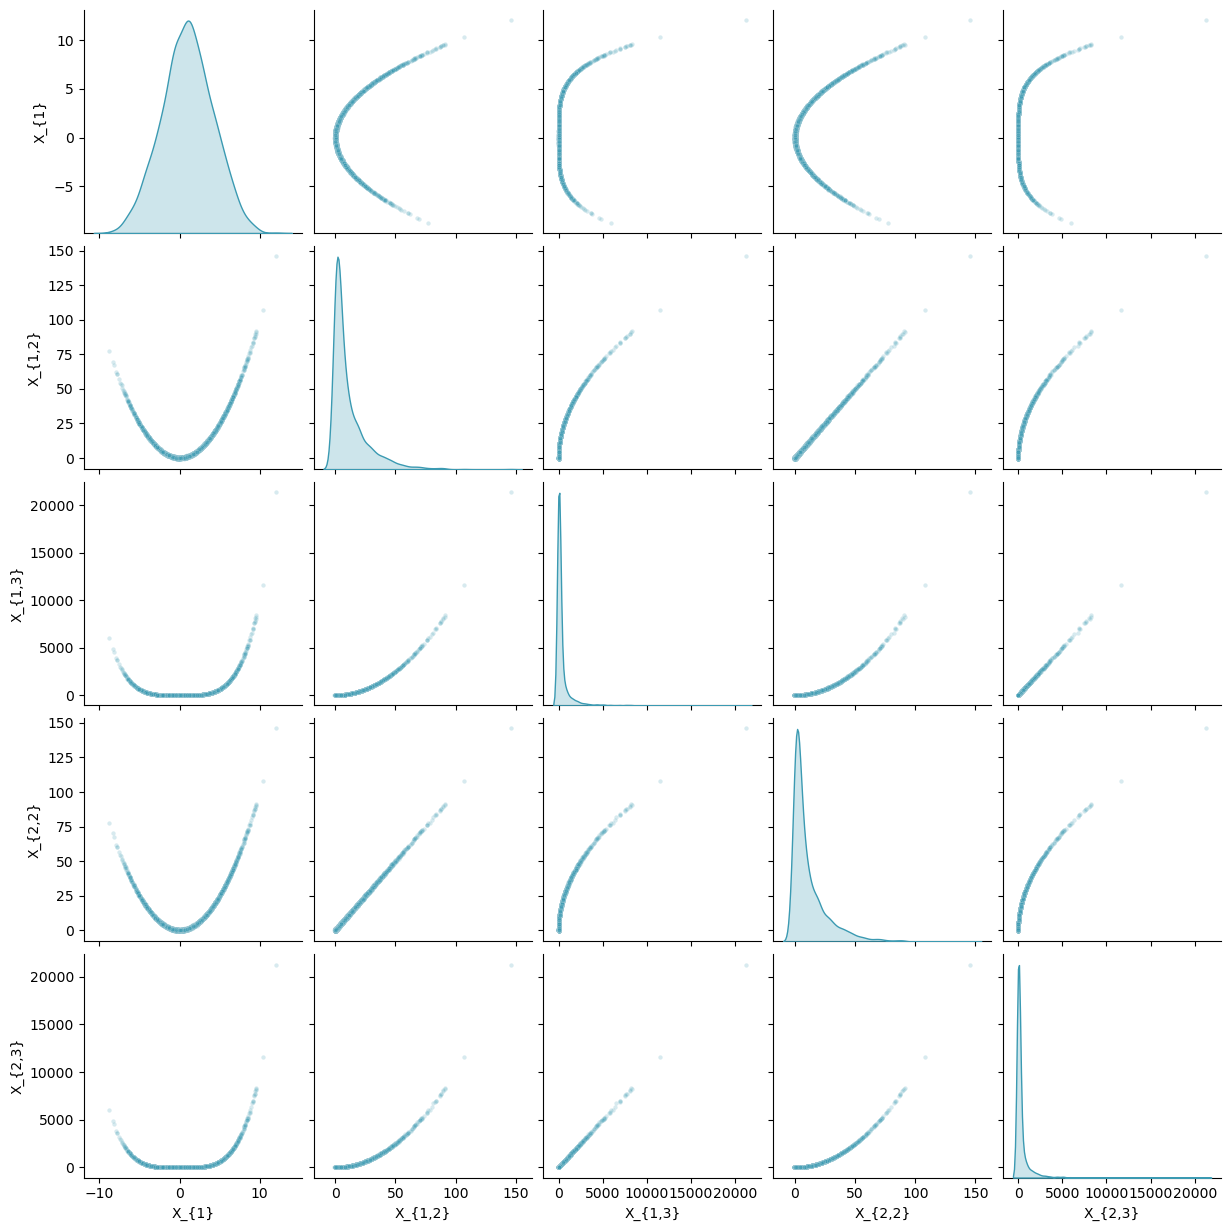

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

import arviz as az
import xarray as xr

from utils import traceplot, acfplot, pairplot

# from rosenbrock import sample_rosenbrock, logpi_rosenbrock, partial_logpi_rosenbrock, hessian_logpi_rosenbrock
from ipynb.fs.full.rosenbrock import sample_rosenbrock, logpi_rosenbrock, partial_logpi_rosenbrock, hessian_logpi_rosenbrock

In [2]:
def ess(X, n1, n2):
    idx = ['X_{1}']

    for j in range(1, n2+1):
        for i in range(2, n1+1):
            idx.append(f'X_{{{j},{i}}}')

    print('ESS for each component:')

    for i in range(X.shape[0]):
        print('\t', idx[i], ': ', az.ess(X[i, :]))

In [3]:
def compare_quantiles(X_mcmc, n1, n2, n_iter=10000):
    quantiles = (0.025, 0.25, 0.5, 0.75, 0.975)

    idx = ['X_{1}']

    for j in range(1, n2+1):
        for i in range(2, n1+1):
            idx.append(f'X_{{{j},{i}}}')

    X_true = sample_rosenbrock(n_iter, n1, n2)

    df = pd.DataFrame(columns=['0.025', '0.25', '0.5', '0.75', '0.975'])

    for i in range(X_true.shape[0]):
        df.loc['True ' + idx[i]] = np.quantile(X_true[i, :], quantiles)
        df.loc['MCMC ' + idx[i]] = np.quantile(X_mcmc[i, :], quantiles)

    return df


In [4]:
def softabs(lam, alpha=1.0, small=1e-8, large=20.0):
    x = alpha * lam

    # Near zero: lam*coth(alpha*lam) ~ 1/alpha + alpha*lam^2/3 + ...
    if abs(x) < small:
        return 1.0 / alpha
    
    # Large positive: coth(x) ~ 1, so lam*coth(x) ~ lam
    # Large negative: coth(x) ~ -1, so lam*coth(x)
    if abs(x) > large:
        return abs(lam)
    
    # Otherwise, directly compute lam*coth(alpha*lam) = lam*cosh(x)/sinh(x)
    return lam * (np.cosh(x) / np.sinh(x))


def project_to_psd(A, method='clip', epsilon=1e-8, alpha=1e3):
    '''
    Project a matrix to the positive semidefinite cone.
    '''
    eigenvalues, eigenvectors = np.linalg.eigh(A)

    if method == 'clip':
        eigenvalues = np.maximum(eigenvalues, epsilon)
        return eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
    
    elif method == 'abs':
        eigenvalues = np.abs(eigenvalues)
        return eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
    
    elif method == 'softabs':
        eigenvalues_soft = np.array([softabs(eigenvalue, alpha) for eigenvalue in eigenvalues])
        return eigenvectors @ np.diag(np.maximum(eigenvalues_soft, epsilon)) @ eigenvectors.T

    else:
        return A

def is_psd(A, tol=1e-8):
    A = (A + A.T) / 2
    
    eigenvalues = np.linalg.eigvalsh(A)

    # Check if all eigenvalues are non-negative (within tolerance)
    return np.all(eigenvalues >= -tol)


# N1 = 3
# N2 = 2
# X_INIT = [0, 0, 0, 0, 0]
# N_ITER = 100000

# X_smmala, accept_rate = SMMALA(
#     logpi=logpi_rosenbrock,
#     partial_logpi=partial_logpi_rosenbrock,
#     hessian_logpi=hessian_logpi_rosenbrock,
#     n_iter=N_ITER,
#     x_init=X_INIT,
#     step_size=0.18,
#     n1=N1,
#     n2=N2,
#     method='softabs'
# )
# print(f'SMMALA acceptance rate: {accept_rate}')

# traceplot(X_smmala)

# acfplot(X_smmala)

# pairplot(X_smmala, N1, N2)

# MCMC Algorithms


## Random Walk Metropolis


In [5]:
def RWM_proposal(x, step_size):
    return x + step_size * np.random.normal(size=x.shape[0])


def RWM(logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        # Proposal state
        y = RWM_proposal(x, step_size)

        logpi_y = logpi(y, **kwargs)

        # Log RWM acceptance rate
        log_acceptance = logpi_y - logpi_x

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x

    acceptance_rate = accepted / n_iter

    return X, acceptance_rate

## Metropolis-Adjusted Langevin Algorithm


In [6]:
def MALA_proposal(x, partial_logpi_x, step_size):
    z = step_size * np.random.normal(size=x.shape[0])

    return x + (1/2) * (step_size**2) * partial_logpi_x + z


def MALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, step_size):
    log_xy = multivariate_normal.logpdf(y, mean=(x + (1/2) * (step_size**2) * partial_logpi_x), cov=(step_size**2))
    log_yx = multivariate_normal.logpdf(x, mean=(y + (1/2) * (step_size**2) * partial_logpi_y), cov=(step_size**2))
    
    return log_yx - log_xy


def MALA(logpi, partial_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        partial_logpi_x = partial_logpi(x, **kwargs)
        
        # Proposal state
        y = MALA_proposal(x, partial_logpi_x, step_size)
        
        logpi_y = logpi(y, **kwargs)
        partial_logpi_y = partial_logpi(y, **kwargs)

        # Log preconditioned MALA acceptance rate
        log_acceptance = logpi_y - logpi_x + MALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate

## Barker Metropolis-Hastings


In [7]:
def stable_log1p_exp(x):
    '''
    Compute log(1 + exp(x)) using the log-sum-exp trick for numerical stability.
    '''
    # return np.where(x > 0, x + np.log1p(np.exp(-x)), np.log1p(np.exp(x)))

    # For large positive x, exp(-x) -> 0, so directly return x
    return np.where(x > 700, x, np.where(x > 0, x + np.log1p(np.exp(-x)), np.log1p(np.exp(x))))


def Barker_proposal(x, partial_logpi_x, step_size):
    # Magnitude
    z = step_size * np.random.normal(size=len(x), scale=1)

    # Direction
    threshold = 1 / (1 + np.exp(- z * partial_logpi_x))
    b = np.where(np.random.uniform(size=1) < threshold, 1, -1) 

    return x + b * z


def Barker_logq_ratio(x, y, partial_logpi_x, partial_logpi_y):
    z = y - x

    logq_xy = - np.log1p(np.exp(- z * partial_logpi_x))
    logq_yx = - np.log1p(np.exp(z * partial_logpi_y))

    # logq_xy = -stable_log1p_exp(-z * partial_logpi_x)
    # logq_yx = -stable_log1p_exp(z * partial_logpi_y)

    return np.sum(logq_yx - logq_xy)
   

def Barker(logpi, partial_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)
    
    for i in range(n_iter):
        partial_logpi_x = partial_logpi(x, **kwargs)

        # Proposal state
        y = Barker_proposal(x, partial_logpi_x, step_size)

        logpi_y = logpi(y, **kwargs)
        partial_logpi_y = partial_logpi(y, **kwargs)

        # Log Barker acceptance rate
        log_acceptance = logpi_y - logpi_x + Barker_logq_ratio(x, y, partial_logpi_x, partial_logpi_y)
        
        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted +=1

        X[:, i] = x
    
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate 

## Simplified Manifold Metropolis-Adjusted Langevin Algorithm


In [8]:
def SMMALA_proposal(x, partial_logpi_x, A_x, step_size, method):
    z = step_size * np.random.normal(size=x.shape[0]) 

    L_x = np.linalg.cholesky(project_to_psd(A_x, method))

    return x + (1/2) * (step_size**2) * A_x @ partial_logpi_x + L_x @ z


def SMMALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, A_x, A_y, step_size, method):
    mean_xy = x + (1/2) * (step_size**2) * A_x @ partial_logpi_x
    mean_yx = y + (1/2) * (step_size**2) * A_y @ partial_logpi_y

    cov_xy = (step_size**2) * A_x
    cov_yx = (step_size**2) * A_y

    log_xy = multivariate_normal.logpdf(y, mean=mean_xy, cov=project_to_psd(cov_xy, method))
    log_yx = multivariate_normal.logpdf(x, mean=mean_yx, cov=project_to_psd(cov_yx, method))
    
    return log_yx - log_xy


def SMMALA(logpi, partial_logpi, hessian_logpi, n_iter, x_init, step_size=1, method='clip', **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        partial_logpi_x = partial_logpi(x, **kwargs)
        H_x = hessian_logpi(x, **kwargs)
        A_x = np.linalg.inv(-H_x)

        # Proposal state
        y = SMMALA_proposal(x, partial_logpi_x, A_x, step_size, method)
        
        logpi_y = logpi(y, **kwargs)
        partial_logpi_y = partial_logpi(y, **kwargs)
        H_y = hessian_logpi(y, **kwargs)
        A_y = np.linalg.inv(-H_y)

        # Log SMMALA acceptance rate
        log_acceptance = logpi_y - logpi_x + SMMALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, A_x, A_y, step_size, method)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate

SMMALA acceptance rate: 0.5642


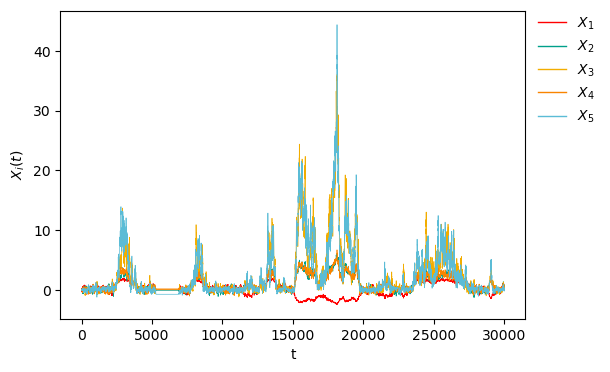

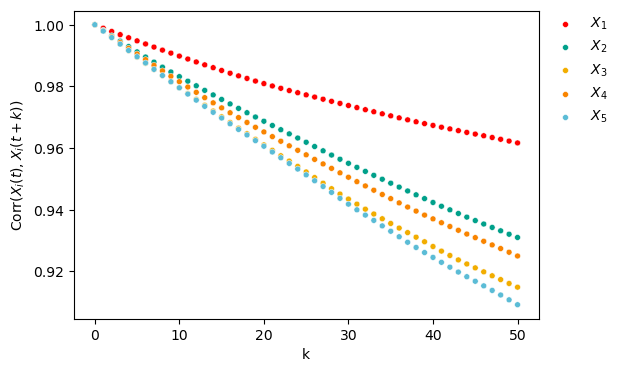

ESS for each component:
	 X_{1} :  7.920194419521074
	 X_{1,2} :  10.10768105797086
	 X_{1,3} :  8.170542754716134
	 X_{2,2} :  10.714417758012114
	 X_{2,3} :  6.831976059116567


0.025      0.25        0.5        0.75        0.975
True X_{1}   -5.082291 -1.151383   1.008491    3.085961     7.233234
MCMC X_{1}   -1.993270 -0.600456   0.093948    0.923926     1.681379
True X_{1,2} -0.202878  1.156045   4.958730   14.098900    54.888923
MCMC X_{1,2} -0.503911 -0.075677   0.552256    1.936464     3.933667
True X_{1,3} -0.259444  1.389622  24.638899  198.850142  3012.921404
MCMC X_{1,3} -0.483549  0.006535   0.352750    3.546753    15.311809
True X_{2,2} -0.189892  1.147067   4.974521   14.120606    54.901328
MCMC X_{2,2} -0.475562  0.035904   0.581373    1.837096     3.912949
True X_{2,3} -0.275130  1.347716  24.739877  199.297284  3013.874537
MCMC X_{2,3} -0.765623 -0.046120   0.325117    3.126327    15.203099

In [34]:
N1 = 3
N2 = 2
X_INIT = [0, 0, 0, 0, 0]
N_ITER = 30000

X_clip, accept_rate = SMMALA(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.3,
    n1=N1,
    n2=N2,
    method='clip'
)
print(f'SMMALA acceptance rate: {accept_rate}')

traceplot(X_clip)
acfplot(X_clip)

ess(X_clip, n1=N1, n2=N2)
compare_quantiles(X_clip, n1=N1, n2=N2)

SMMALA acceptance rate: 0.57304


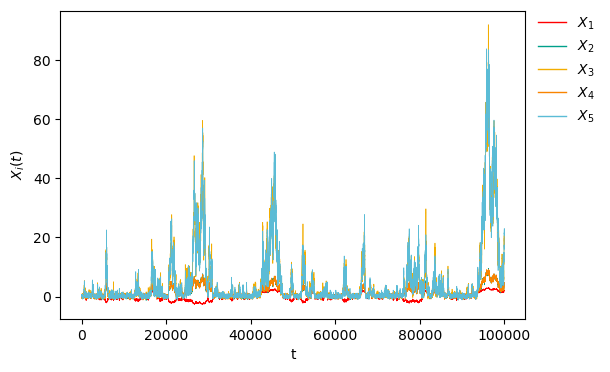

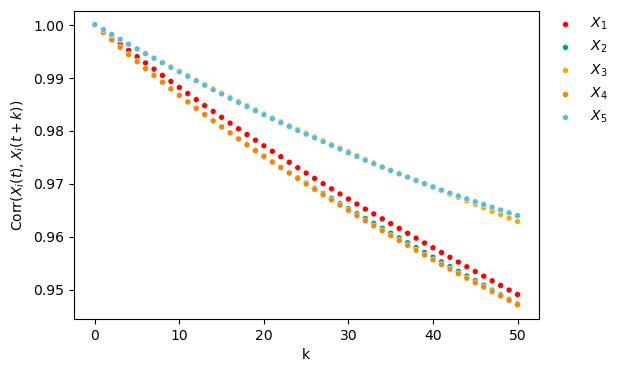

ESS for each component:
	 X_{1} :  18.54076486903313
	 X_{1,2} :  38.21167762479195
	 X_{1,3} :  40.51398075769591
	 X_{2,2} :  39.10354188669765
	 X_{2,3} :  41.03980539468414


0.025      0.25        0.5        0.75        0.975
True X_{1}   -5.247042 -1.121699   1.021517    3.139062     7.123509
MCMC X_{1}   -2.071873 -0.762285   0.137815    0.981894     2.434160
True X_{1,2} -0.180051  1.139764   5.028965   14.523535    53.999056
MCMC X_{1,2} -0.389966  0.234124   0.810657    2.125958     6.053910
True X_{1,3} -0.256976  1.337918  25.262174  210.786962  2915.981423
MCMC X_{1,3} -0.402178  0.146078   0.741704    4.560008    36.575521
True X_{2,2} -0.191352  1.155426   5.000103   14.557402    53.763317
MCMC X_{2,2} -0.411470  0.229819   0.828335    2.118209     6.091049
True X_{2,3} -0.261575  1.338930  25.045194  211.687329  2890.018492
MCMC X_{2,3} -0.421899  0.148515   0.779128    4.525833    37.079029

In [30]:
X_abs, accept_rate = SMMALA(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.35,
    n1=N1,
    n2=N2,
    method='abs'
)
print(f'SMMALA acceptance rate: {accept_rate}')

traceplot(X_abs)
acfplot(X_abs)

ess(X_abs, n1=N1, n2=N2)
compare_quantiles(X_abs, n1=N1, n2=N2)

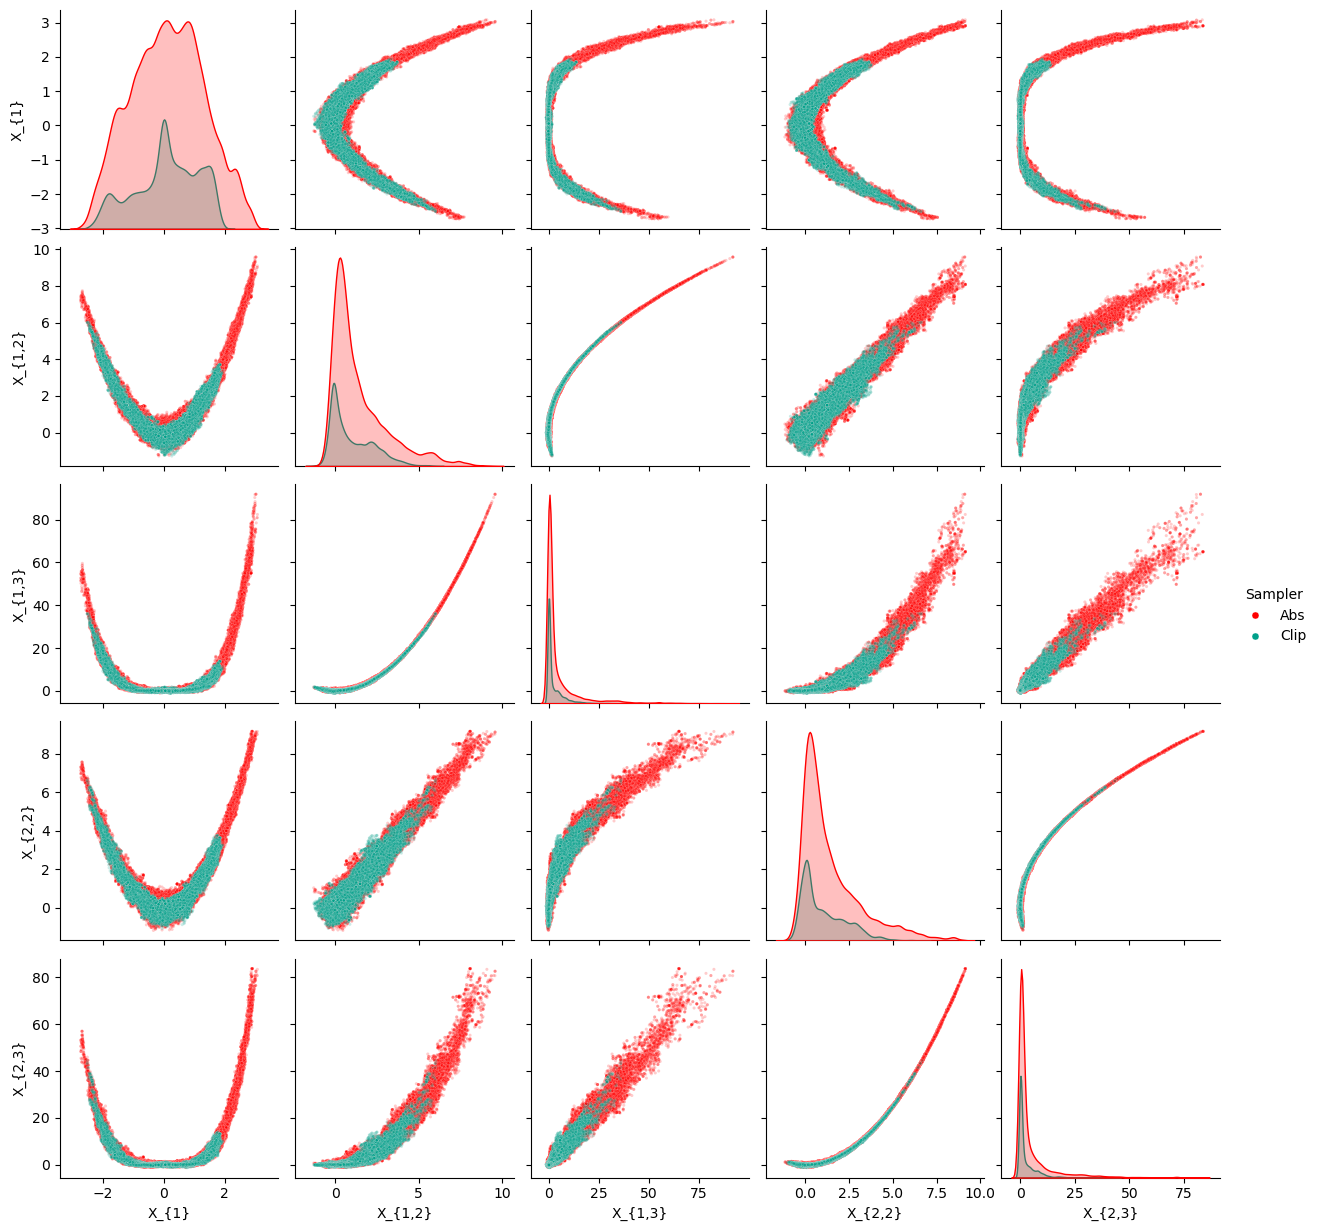

In [35]:
pairplot([X_abs, X_clip], N1, N2, sampler_names=['Abs', 'Clip'])

## Simplified Manifold Barker Metropolis-Hastings


In [12]:
def SMBarker_proposal(x, partial_logpi_x, L_x, step_size=1):
    # Magnitude
    z = step_size * np.random.normal(size=len(x), scale=1)

    # Direction
    threshold = 1 / (1 + np.exp(- z * (partial_logpi_x @ L_x)))
    b = np.where(np.random.uniform(size=1) < threshold, 1, -1) 

    return x + L_x @ (b * z)


def SMBarker_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, L_x, L_y):
    z_xy = np.linalg.inv(L_x) @ (x - y)
    z_yx = np.linalg.inv(L_y) @ (y - x)

    logq_xy = - np.log1p(np.exp(z_xy @ (partial_logpi_x @ L_x)))
    logq_yx = - np.log1p(np.exp(z_yx @ (partial_logpi_y @ L_y)))

    return np.sum(logq_yx - logq_xy)


def SMBarker(logpi, partial_logpi, hessian_logpi, n_iter, x_init, step_size=1, method='clip', **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        partial_logpi_x = partial_logpi(x, **kwargs)
        H_x = hessian_logpi(x, **kwargs)
        A_x = project_to_psd(np.linalg.inv(-H_x), method)
        L_x = np.linalg.cholesky(A_x)

        # Propose candidate state
        y = SMBarker_proposal(x, partial_logpi_x, L_x, step_size)

        logpi_y = logpi(y, **kwargs)
        partial_logpi_y = partial_logpi(y, **kwargs)
        H_y = hessian_logpi(y, **kwargs)
        A_y = project_to_psd(np.linalg.inv(-H_y), method)
        L_y = np.linalg.cholesky(A_y)

        # Log SMBarker acceptance rate
        log_acceptance = logpi_y - logpi_x + SMBarker_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, L_x, L_y)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate


SMBarker acceptance rate: 0.5492


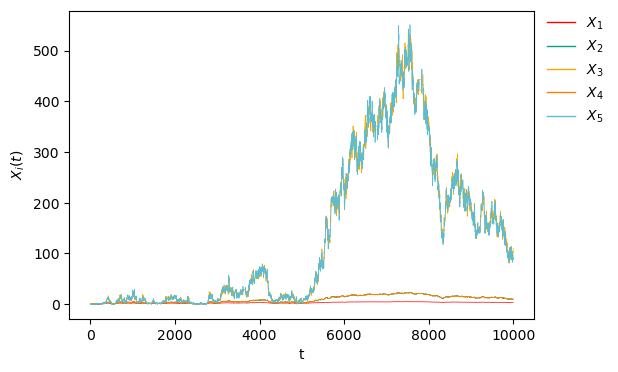

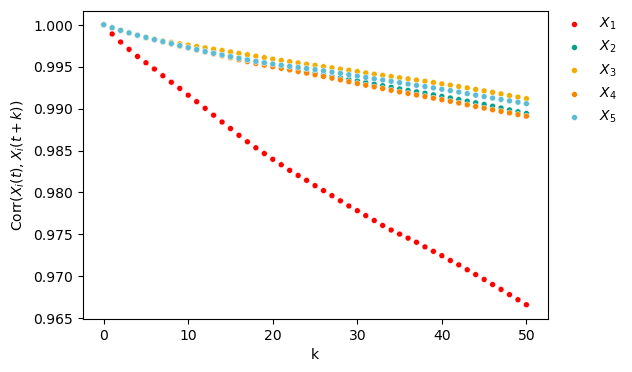

ESS for each component:
	 X_{1} :  1.4120071552614093
	 X_{1,2} :  1.4143669031934254
	 X_{1,3} :  1.4132220578739427
	 X_{2,2} :  1.4122324945153328
	 X_{2,3} :  1.4110326401226236


0.025      0.25        0.5        0.75        0.975
True X_{1}   -5.305203 -1.232294   0.994290    3.105199     7.141139
MCMC X_{1}    0.140733  1.709023   2.645669    3.890592     4.639843
True X_{1,2} -0.209170  1.234307   5.106279   14.557055    54.035554
MCMC X_{1,2}  0.099041  2.866943   6.988960   15.118691    21.592616
True X_{1,3} -0.230072  1.554678  25.966535  212.118272  2920.522808
MCMC X_{1,3} -0.084358  8.097028  48.631170  228.478395   466.421722
True X_{2,2} -0.178590  1.219741   5.055823   14.639704    53.894489
MCMC X_{2,2}  0.099318  2.862716   6.969284   15.072743    21.499327
True X_{2,3} -0.229039  1.528914  25.619761  214.148560  2904.892241
MCMC X_{2,3} -0.004277  8.008051  48.534290  227.159657   462.402213

In [13]:
N1 = 3
N2 = 2
X_INIT = [0, 0, 0, 0, 0]
N_ITER = 10000

X_clip, accept_rate = SMBarker(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.9,
    n1=N1,
    n2=N2,
    method='clip'
)
print(f'SMBarker acceptance rate: {accept_rate}')

traceplot(X_clip)
acfplot(X_clip)

ess(X_clip, n1=N1, n2=N2)
compare_quantiles(X_clip, n1=N1, n2=N2)

SMBarker acceptance rate: 0.5342


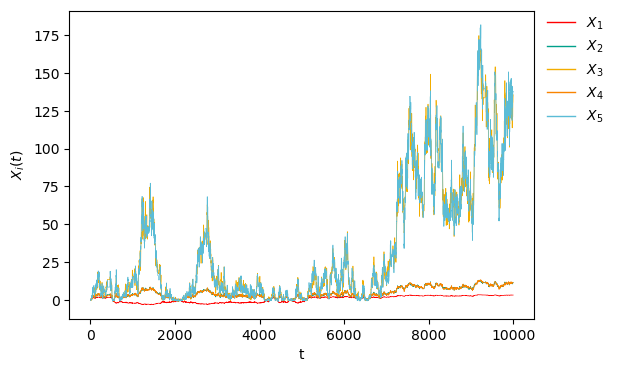

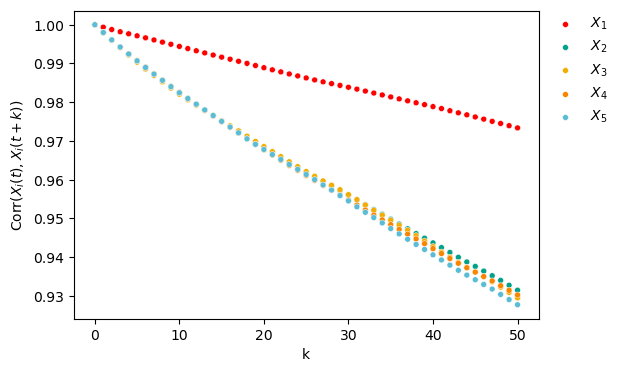

ESS for each component:
	 X_{1} :  1.3921158273130374
	 X_{1,2} :  2.456127877741802
	 X_{1,3} :  2.5016242161444424
	 X_{2,2} :  2.522450192179051
	 X_{2,3} :  2.5096514845002376


0.025      0.25        0.5        0.75        0.975
True X_{1}   -5.329190 -1.134567   1.017215    3.130865     7.342286
MCMC X_{1}   -2.635028 -1.479666   1.379528    2.764374     3.420989
True X_{1,2} -0.189522  1.191014   5.037612   14.556663    57.346652
MCMC X_{1,2}  0.064507  2.053486   3.571198    7.759933    11.547804
True X_{1,3} -0.241554  1.408865  25.351894  212.168894  3288.548295
MCMC X_{1,3} -0.084606  4.023827  12.593057   59.980111   133.485795
True X_{2,2} -0.177882  1.200412   5.019871   14.550636    57.092014
MCMC X_{2,2}  0.053757  2.068608   3.551373    7.720630    11.759747
True X_{2,3} -0.246372  1.496576  25.251298  211.576463  3259.495028
MCMC X_{2,3} -0.127668  4.134025  12.506459   59.415629   138.120876

In [14]:
X_abs, accept_rate = SMBarker(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.8,
    n1=N1,
    n2=N2,
    method='abs'
)
print(f'SMBarker acceptance rate: {accept_rate}')

traceplot(X_abs)
acfplot(X_abs)

ess(X_abs, n1=N1, n2=N2)
compare_quantiles(X_abs, n1=N1, n2=N2)

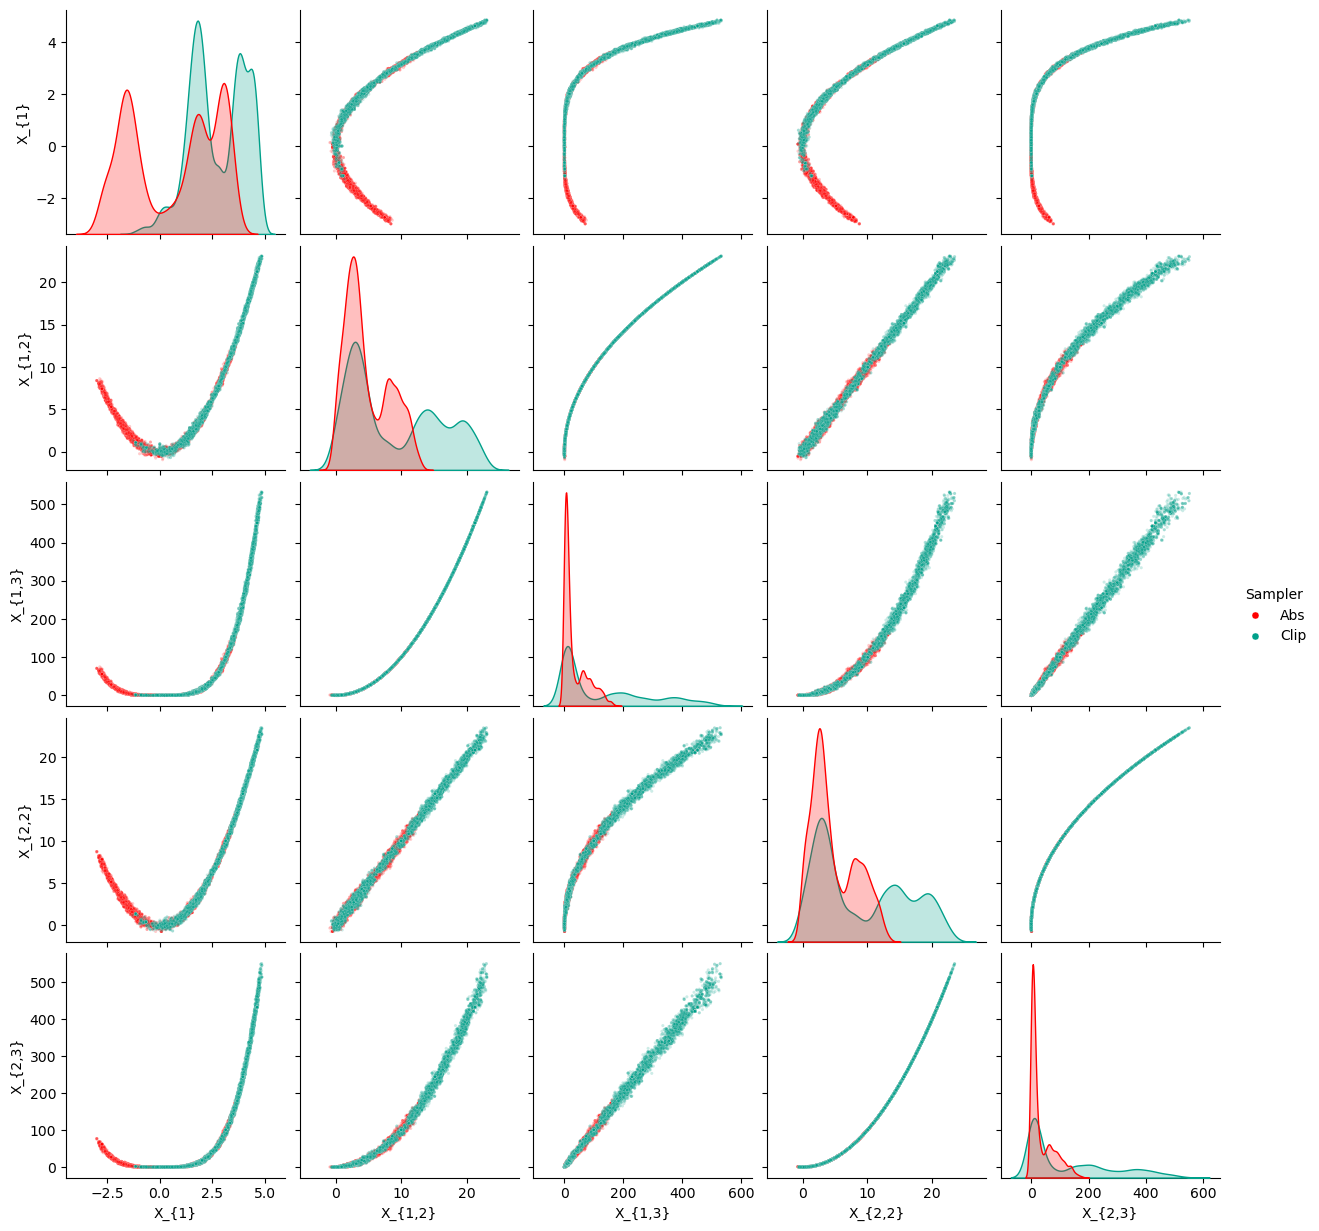

In [15]:
pairplot([X_abs, X_clip], N1, N2, sampler_names=['Abs', 'Clip'])

# Experiment


Standard parametrization:

-   $\mu = 1$
-   $a  = 1/20$
-   $b_{i, j} = 100/20 \quad (\forall i, j)$


## N1 = 2, N2 = 2


SMMALA acceptance rate: 0.57949


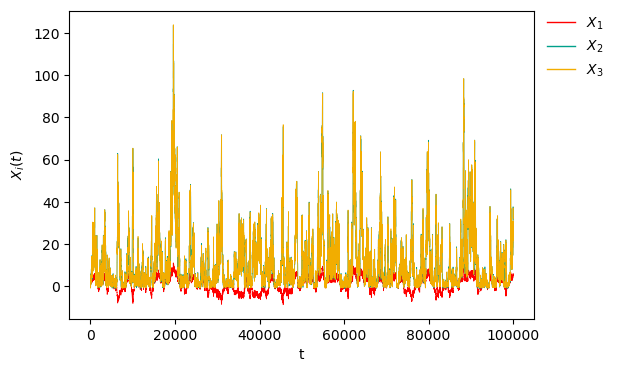

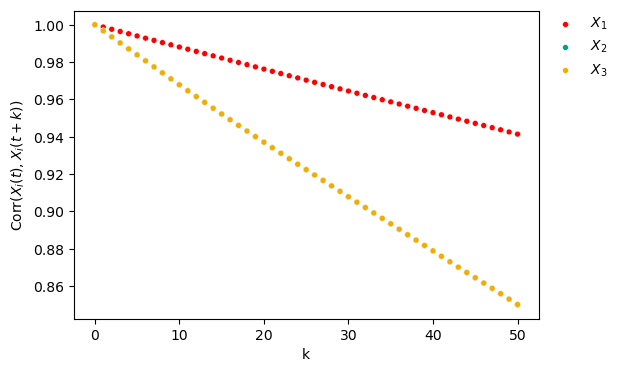

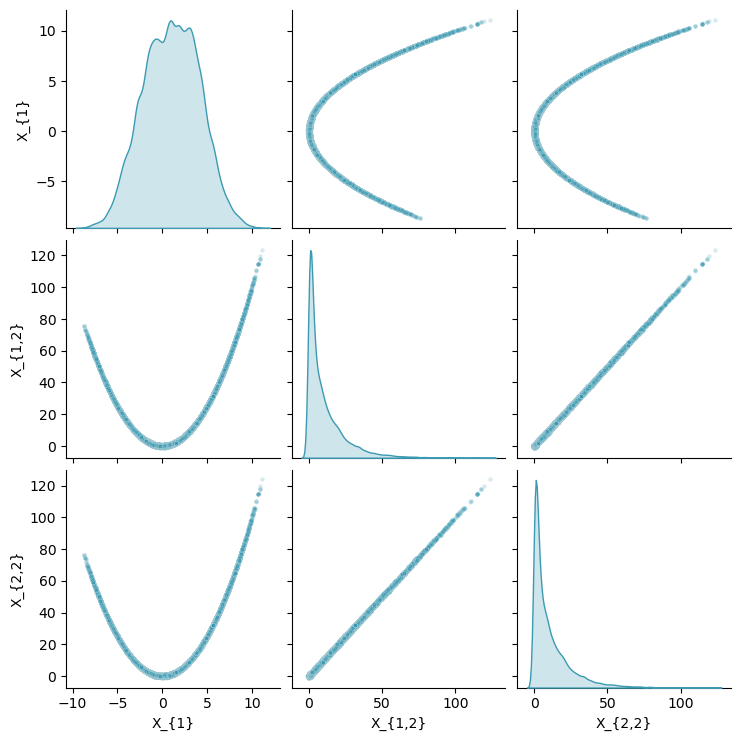

In [45]:
N1 = 2
N2 = 2
X_INIT = [0, 0, 0]
N_ITER = 100000

X_smmalas, accept_rate = SMMALA(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.7,
    n1=N1,
    n2=N2,
    method='softabs'
)
print(f'SMMALA acceptance rate: {accept_rate}')

traceplot(X_smmalas)
acfplot(X_smmalas)
pairplot(X_smmalas, N1, N2)

SMMALA acceptance rate: 0.58084


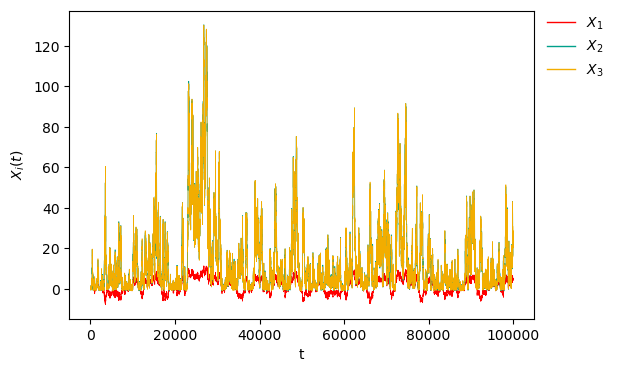

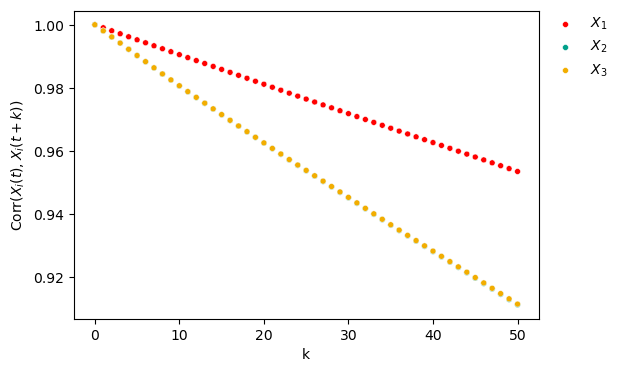

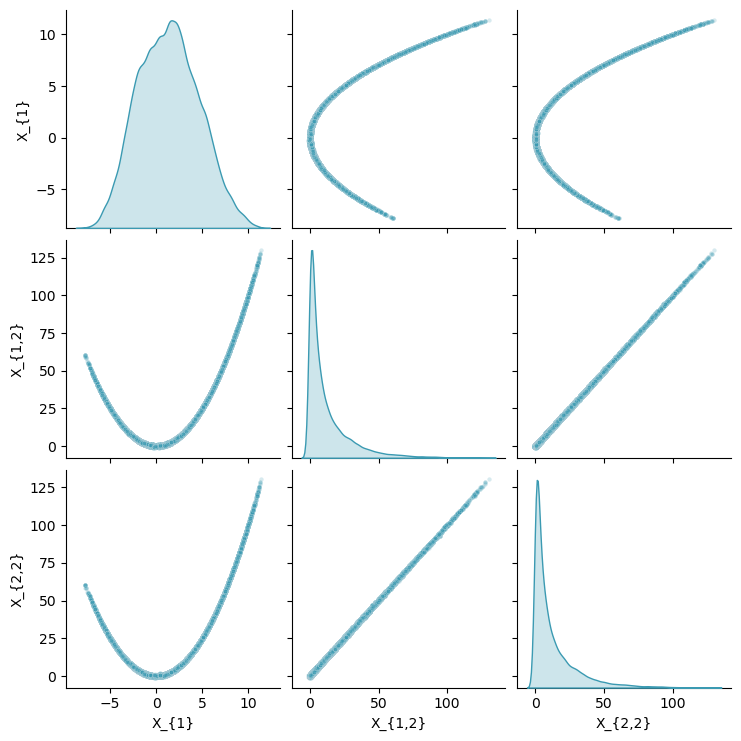

In [47]:
N1 = 2
N2 = 2
X_INIT = [0, 0, 0]
N_ITER = 100000

X_smmala, accept_rate = SMMALA(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.7,
    n1=N1,
    n2=N2,
    method='abs'
)
print(f'SMMALA acceptance rate: {accept_rate}')

traceplot(X_smmala)
acfplot(X_smmala)
pairplot(X_smmala, N1, N2)

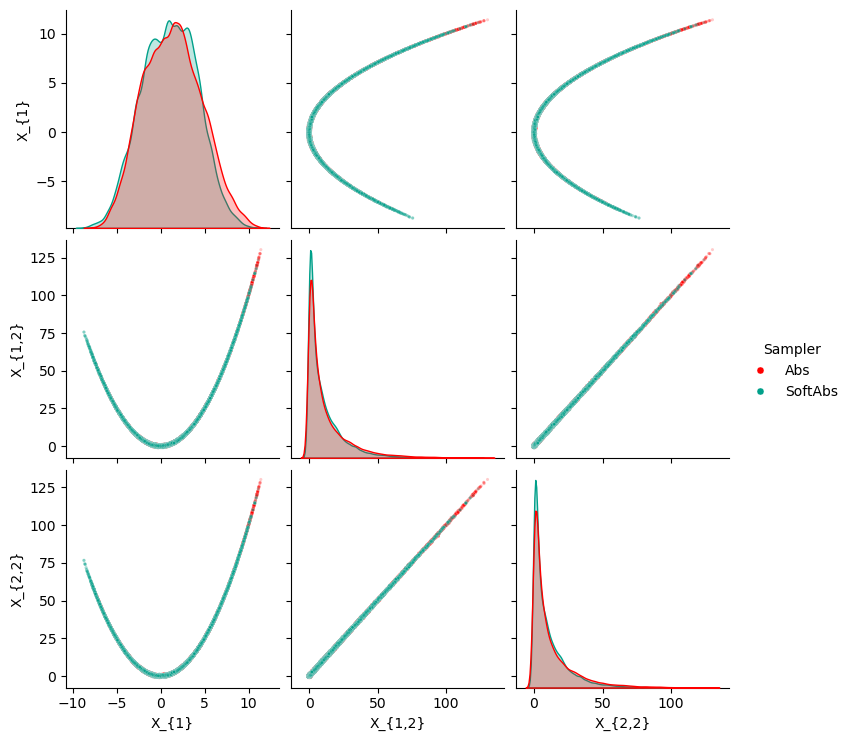

In [48]:
pairplot([X_smmala, X_smmalas], n1=N1, n2=N2, sampler_names=['Abs', 'SoftAbs'])

In [46]:
# X_smbarker, accept_rate = SMBarker(
#     logpi=logpi_rosenbrock,
#     partial_logpi=partial_logpi_rosenbrock,
#     hessian_logpi=hessian_logpi_rosenbrock,
#     n_iter=N_ITER,
#     x_init=X_INIT,
#     step_size=1.15,
#     n1=N1,
#     n2=N2,
# )
# print(f'SMBarker acceptance rate: {accept_rate}')

# traceplot(X_smbarker)
# acfplot(X_smbarker)
# pairplot(X_smbarker, N1, N2)

X_smbarker, accept_rate = SMBarker(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=1,
    n1=N1,
    n2=N2,
    method='abs'
)
print(f'SMBarker acceptance rate: {accept_rate}')

traceplot(X_smbarker)
acfplot(X_smbarker)
pairplot(X_smbarker, N1, N2)

KeyboardInterrupt: 

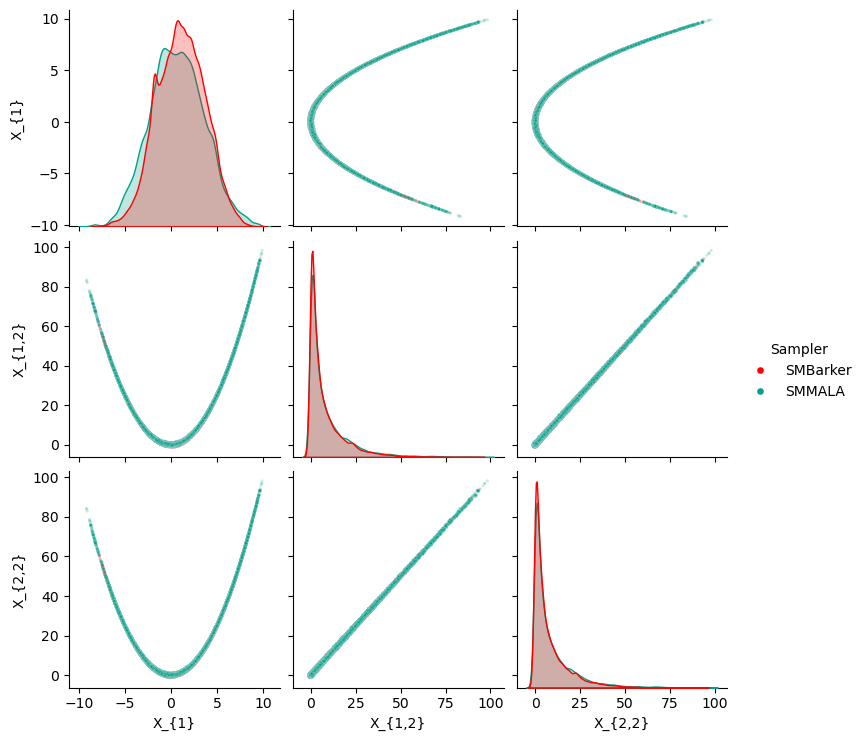

In [40]:
pairplot([X_smbarker, X_smmala], n1=N1, n2=N2, sampler_names=['SMBarker', 'SMMALA'])

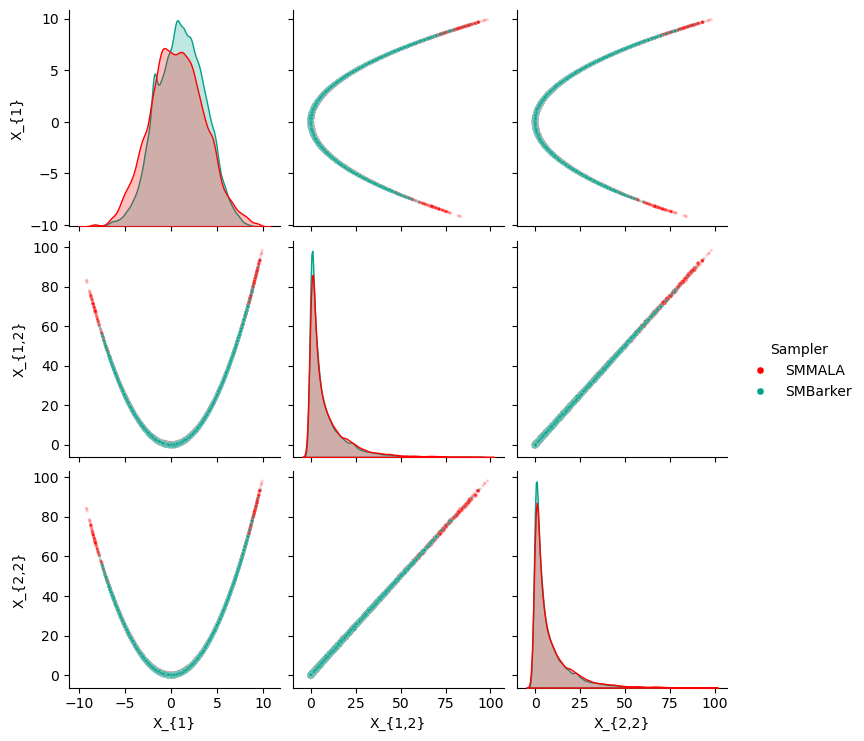

In [43]:
pairplot([X_smmala, X_smbarker], n1=N1, n2=N2, sampler_names=['SMMALA', 'SMBarker'])

In [ ]:
X_true = sample_rosenbrock(n_iter=N_ITER, n1=N1, n2=N2)

pairplot([X_true, X_smbarker, X_smmala], n1=N1, n2=N2, sampler_names=['X_true', 'SMBarker', 'SMMALA'])

In [41]:
print('SMMALA')
ess(X_smmala, n1=N1, n2=N2)
compare_quantiles(X_smmala, n1=N1, n2=N2)

SMMALA
ESS for each component:
	 X_{1} :  75.49931522144541
	 X_{1,2} :  169.01319521202862
	 X_{2,2} :  168.47947675672853


0.025      0.25       0.5       0.75      0.975
True X_{1}   -5.216455 -1.153307  0.986308   3.105400   7.130491
MCMC X_{1}   -4.947946 -1.358779  0.612239   2.650568   6.519650
True X_{1,2} -0.169482  1.108849  5.135650  14.630920  54.075485
MCMC X_{1,2} -0.214402  1.006453  4.185778  12.112468  44.378060
True X_{2,2} -0.213730  1.129053  5.128272  14.653980  54.111998
MCMC X_{2,2} -0.221305  0.991917  4.164160  12.087161  44.329895

In [42]:
print('SMBarker')
ess(X_smbarker, n1=N1, n2=N2)
compare_quantiles(X_smbarker, n1=N1, n2=N2)

SMBarker
ESS for each component:
	 X_{1} :  205.097755349932
	 X_{1,2} :  395.66660129512735
	 X_{2,2} :  387.8141687972109


0.025      0.25       0.5       0.75      0.975
True X_{1}   -5.168278 -1.141009  0.985121   3.092853   7.136618
MCMC X_{1}   -3.931456 -0.813011  1.059292   2.911945   5.964366
True X_{1,2} -0.206351  1.135673  4.993777  14.161190  53.654659
MCMC X_{1,2} -0.293797  0.823815  3.629011  10.595551  37.077704
True X_{2,2} -0.215207  1.147789  4.986345  14.164444  53.499785
MCMC X_{2,2} -0.299821  0.815966  3.635976  10.587447  37.037946

## N1 = 3, N2 = 2


In [21]:
N1 = 3
N2 = 2
X_INIT = [0, 0, 0, 0, 0]
N_ITER = 100000

SMMALA acceptance rate: 0.62584


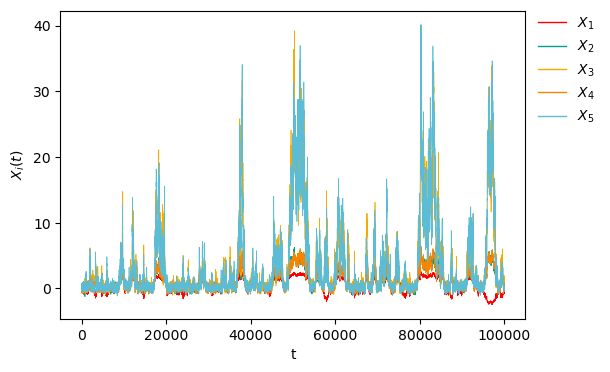

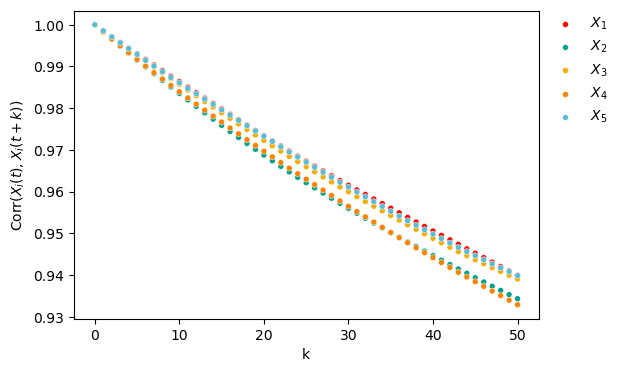

ESS for each component:
	 X_{1} :  42.48069042389922
	 X_{1,2} :  49.15418357128942
	 X_{1,3} :  48.291932564096584
	 X_{2,2} :  50.75600077838395
	 X_{2,3} :  54.25601279736548


0.025      0.25        0.5        0.75        0.975
True X_{1}   -5.204973 -1.095663   0.965825    3.107699     7.352771
MCMC X_{1}   -1.487943 -0.143845   0.604466    1.318348     2.149725
True X_{1,2} -0.205946  1.092766   4.971704   14.638945    56.778611
MCMC X_{1,2} -0.395333  0.206188   0.761866    1.920511     4.733285
True X_{1,3} -0.262746  1.182100  24.704345  213.969726  3223.985903
MCMC X_{1,3} -0.395737  0.152263   0.695457    3.656183    22.489294
True X_{2,2} -0.198575  1.072402   5.004420   14.594314    56.591041
MCMC X_{2,2} -0.403427  0.191747   0.749872    1.925889     4.748881
True X_{2,3} -0.277662  1.186291  25.059078  212.733697  3202.458575
MCMC X_{2,3} -0.447108  0.116757   0.670338    3.715231    22.582887

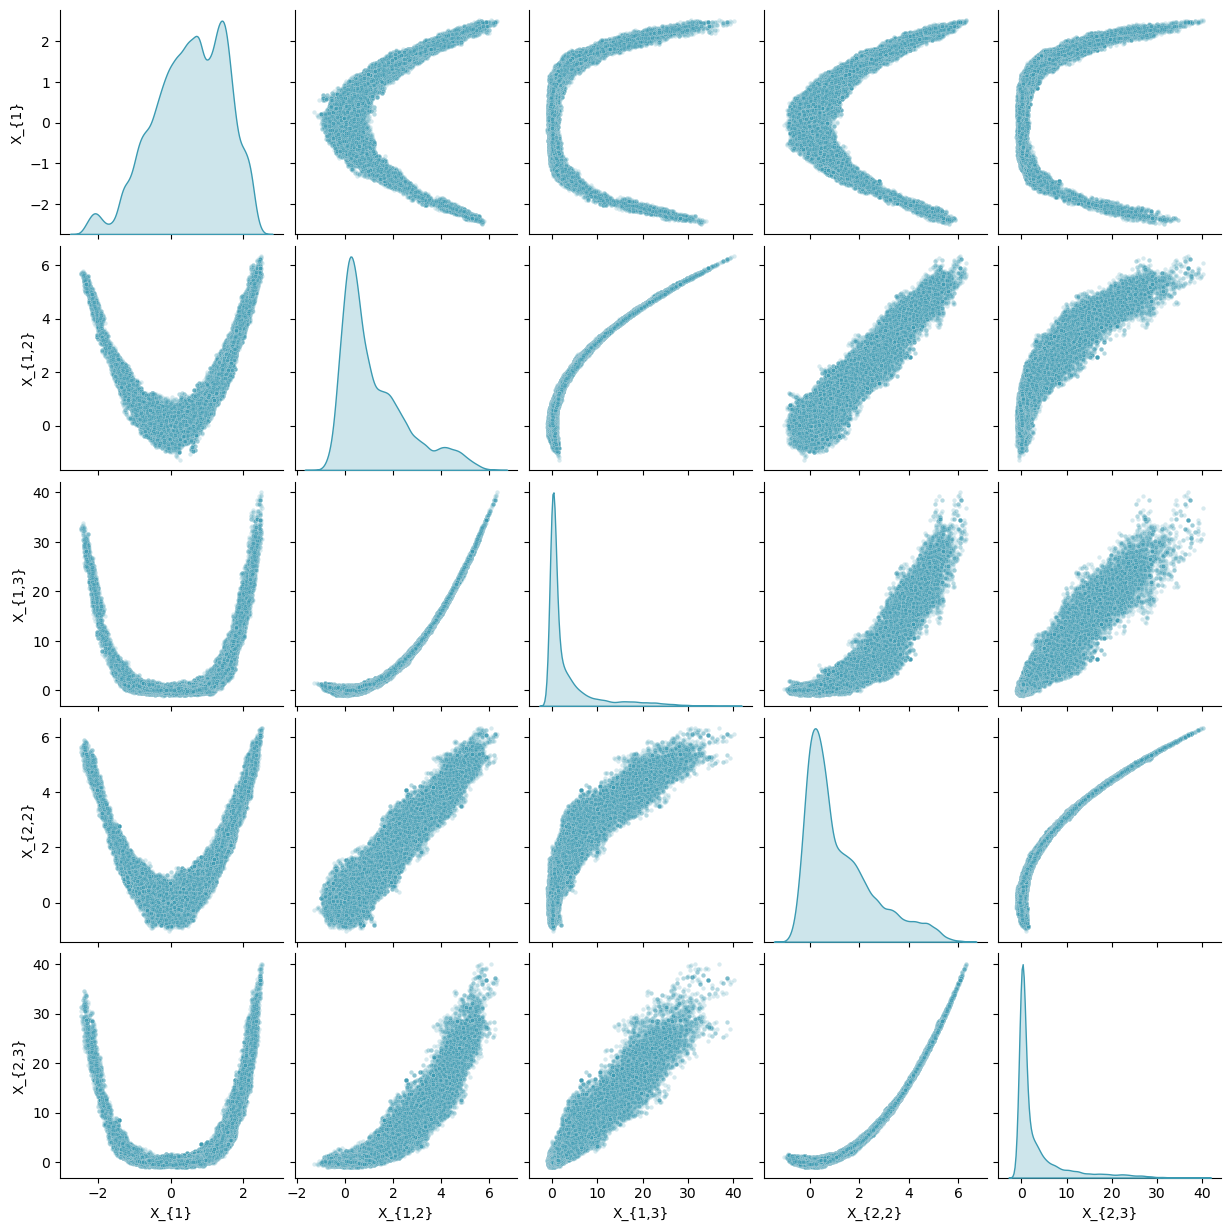

In [24]:
X_smmala, accept_rate = SMMALA(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.28,
    n1=N1,
    n2=N2,
    method='abs'
)
print(f'SMMALA acceptance rate: {accept_rate}')

traceplot(X_smmala)

acfplot(X_smmala)

pairplot(X_smmala, N1, N2)

ess(X_smmala, n1=N1, n2=N2)
compare_quantiles(X_smmala, n1=N1, n2=N2)

SMBarker acceptance rate: 0.65125


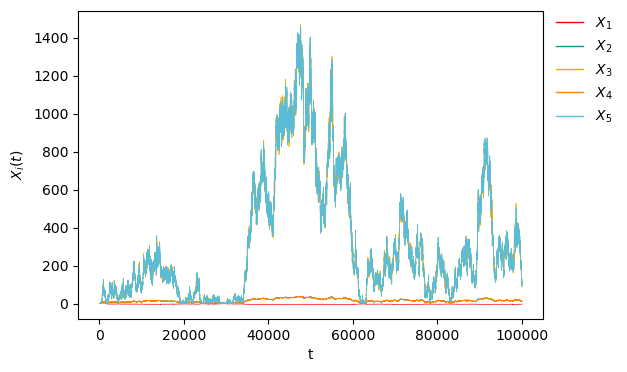

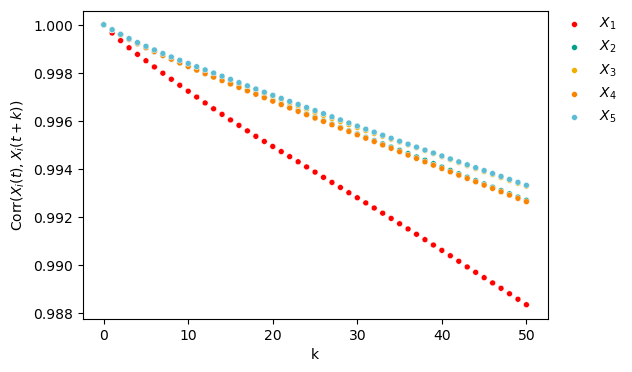

ESS for each component:
	 X_{1} :  11.149443083493134
	 X_{1,2} :  11.09774285240315
	 X_{1,3} :  11.11860421497649
	 X_{2,2} :  11.116414691619147
	 X_{2,3} :  11.11117391776539


0.025       0.25         0.5        0.75        0.975
True X_{1}   -5.097149  -1.087662    1.017563    3.189885     7.201934
MCMC X_{1}   -5.775924  -4.700100   -3.729732   -2.835952     0.180853
True X_{1,2} -0.192074   1.134100    5.060334   14.730235    55.088317
MCMC X_{1,2}  1.202818   8.130630   13.923312   22.091839    33.407592
True X_{1,3} -0.265921   1.330767   25.660322  216.778400  3034.965319
MCMC X_{1,3}  1.365750  65.934231  193.743059  487.842377  1115.948793
True X_{2,2} -0.196463   1.117118    5.048807   14.722727    54.972859
MCMC X_{2,2}  1.189539   8.117074   13.893599   22.101831    33.398671
True X_{2,3} -0.269855   1.310149   25.492344  216.548625  3022.308781
MCMC X_{2,3}  1.267367  65.662331  192.911659  488.391735  1115.107755

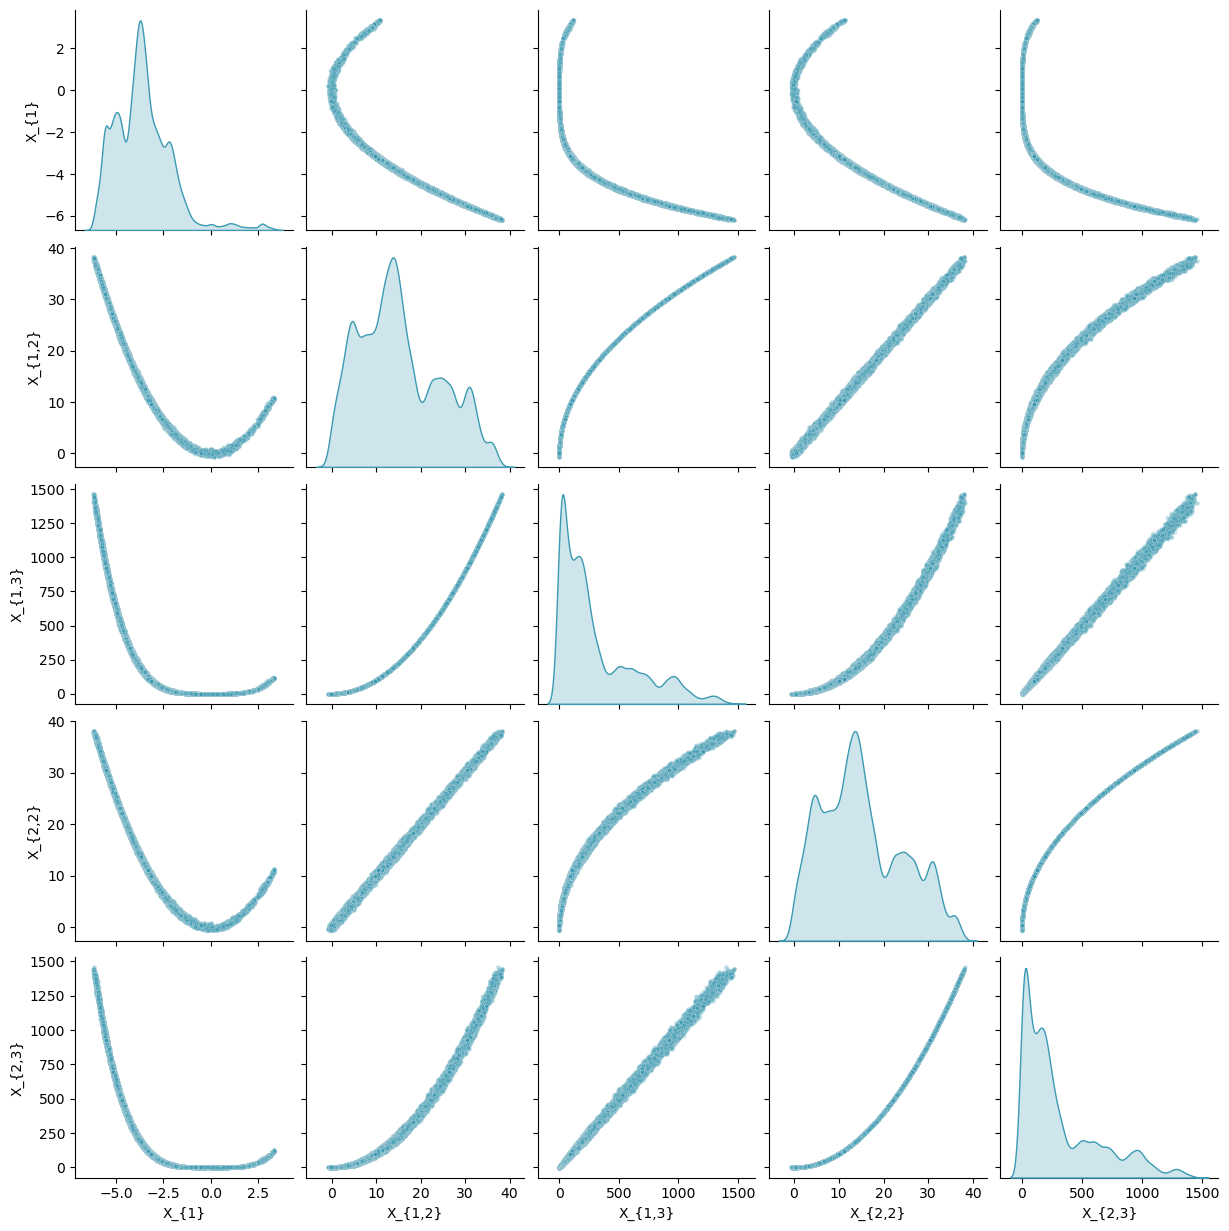

In [25]:
X_smbarker, accept_rate = SMBarker(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=N_ITER,
    x_init=X_INIT,
    step_size=0.75,
    n1=N1,
    n2=N2,
    method='clip',
)
print(f'SMBarker acceptance rate: {accept_rate}')

traceplot(X_smbarker)

acfplot(X_smbarker)

pairplot(X_smbarker, N1, N2)

ess(X_smbarker, n1=N1, n2=N2)
compare_quantiles(X_smbarker, n1=N1, n2=N2)

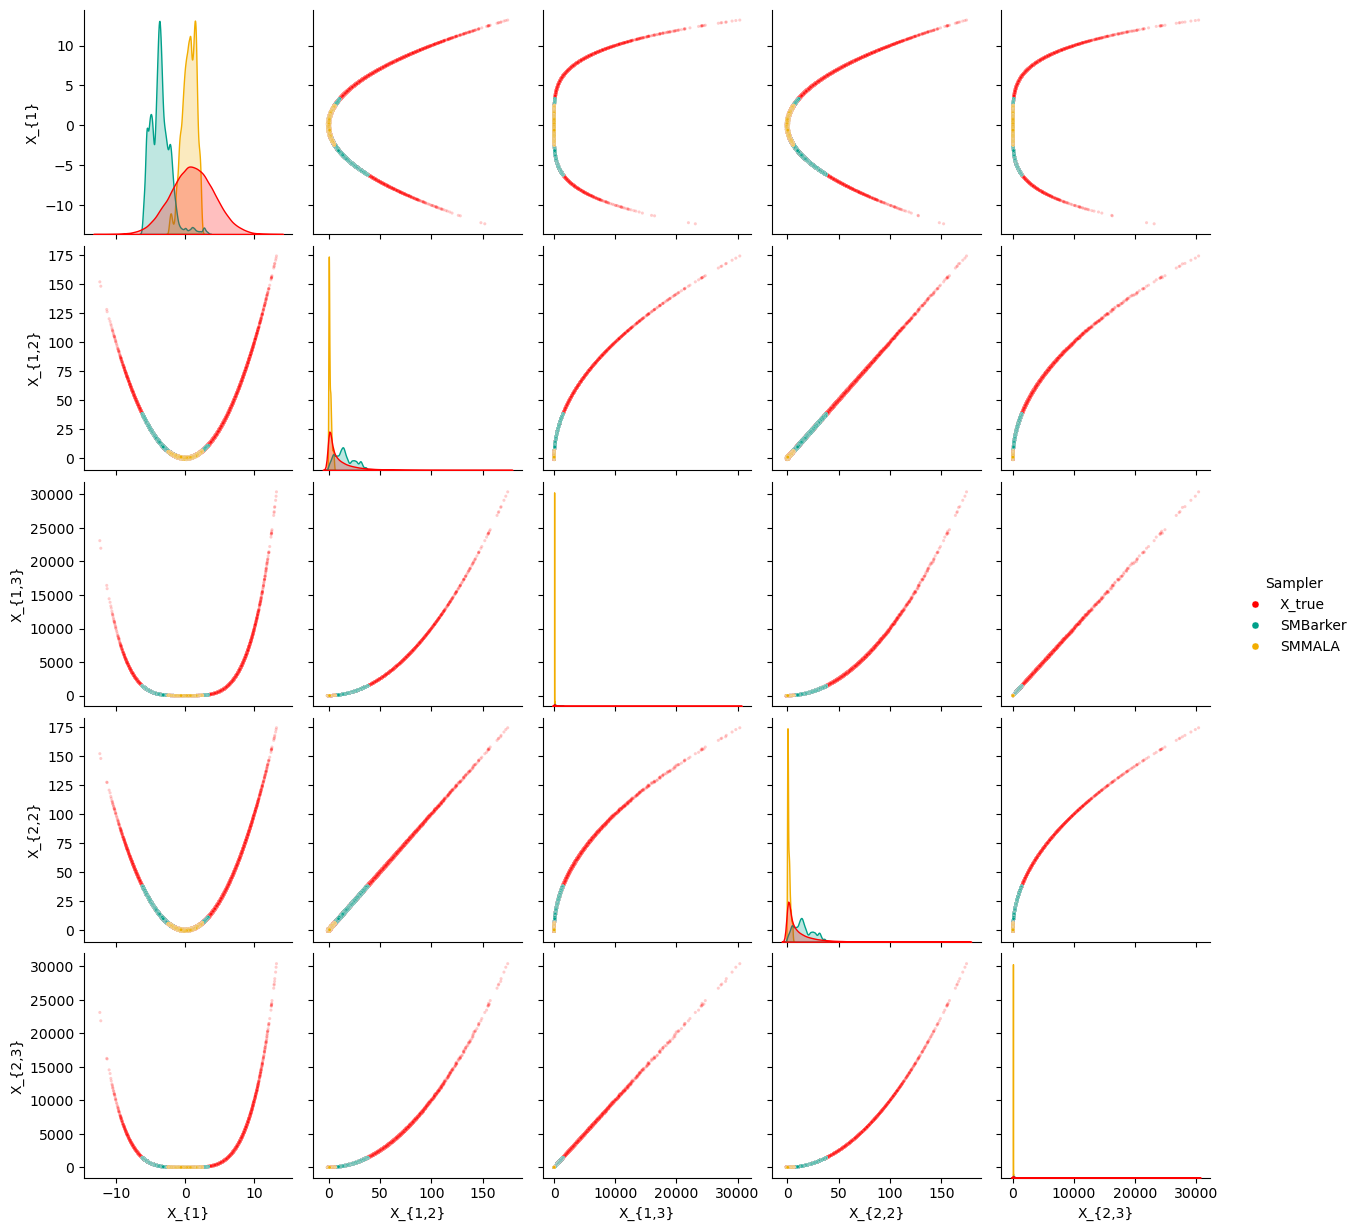

In [26]:
X_true = sample_rosenbrock(n_iter=N_ITER, n1=N1, n2=N2)

pairplot([X_true, X_smbarker, X_smmala], n1=N1, n2=N2, sampler_names=['X_true', 'SMBarker', 'SMMALA'])